<a href="https://colab.research.google.com/github/ramirogalvez/colab_notebooks/blob/master/Sentiment_Analysis_with_roBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Ramiro Gálvez (Twitter handle: [@RamiroHGalvez](https://twitter.com/RamiroHGalvez))

**Date**: 2020-08-26

In [ ]:
!pip install -qq transformers
!gdown --id 1CD7s5rnLbsQ7Bgx6WrSv6QwJe6_Q7dvy
!nvidia-smi

Downloading...
From: https://drive.google.com/uc?id=1CD7s5rnLbsQ7Bgx6WrSv6QwJe6_Q7dvy
To: /content/imdb_data.zip
127MB [00:00, 271MB/s]
Wed Aug 26 02:13:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------

In [ ]:
import requests
import zipfile
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Seteos de la notebook
%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# roBERTa para Análisis de Sentimiento

En esta notebook se presenta el código para entrenar un modelo de análisis de sentimiento a partir de un modelo BERT (roBERTa) pre entrenado (transfer learning). La notebook hace uso fuerte de la librería transformers de huggingface y puede adaptarse de manera simple (trivial) a otros problemas de clasificación de textos (cortos).

## Carga de los datos

In [ ]:
def process_document(metadata, document):

    m_id, rating = [int(e) for e in metadata.replace(".txt", "").split("_")]
    r_class = 0 if rating <= 4 else 1

    return {"movie_id": m_id,
            "rating": rating,
            "content": document,
            "sentiment": r_class}


def carga_path(data_path):

    comments_data = []
    for d in os.listdir(data_path):
        with open(data_path + d, encoding="utf-8") as f:
            comments_data.append(process_document(d, f.read()))

    return pd.DataFrame(comments_data)


def carga_datos_imdb(tr_path, ts_path):

    # Descarga el archivo zip y lo descomprime en el server de Google
    z = zipfile.ZipFile("imdb_data.zip")
    z.extractall()

    # Carga los datos de entrenamiento
    train_data = carga_path(tr_path)

    # Carga los datos de testeo
    test_data = carga_path(ts_path)

    return train_data, test_data

In [ ]:
train_data, test_data = carga_datos_imdb("./imdb_data/imdb_data/train_corpus/",
                                         "./imdb_data/imdb_data/test_corpus/")
class_names = ['negative', 'positive']

train_data, val_data = train_test_split(train_data,
                                        test_size=0.1,
                                        random_state=RANDOM_SEED)

In [ ]:
train_data.head()

,movie_id,rating,content,sentiment
4484,3077,1,Hobgoblins... what a concept. Rick Sloan was a...,0
11558,7358,1,This Lifetime style movie takes the middle age...,0
16900,8317,8,A remarkable example of cinematic alchemy at w...,1
8936,8127,2,"Currently, this film is listed on IMDb as the ...",0
10782,10454,9,Before Sunrise is romance for the slacker gene...,1


## Configuración de los data loaders para roBERTa

In [ ]:
class SentimentDataset(Dataset):

    def __init__(self, contents, targets, tokenizer, max_len):
        self.contents = contents
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.contents)


    def __getitem__(self, item):
        content = str(self.contents[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(content,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation=True)

        return {'content_text': content,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}


def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SentimentDataset(contents=df.content.to_numpy(),
                           targets=df.sentiment.to_numpy(),
                           tokenizer=tokenizer,
                           max_len=max_len)
    
    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

In [ ]:
MAX_LEN = 400
BATCH_SIZE = 16
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

## Seteo del modelo propuesto (roBERTa + dropout + fully connected)

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes, freeze = False):
    
        super(SentimentClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        output = self.drop(pooled_output)

        return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names), freeze=False)
model = model.to(device)

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=total_steps // 10,
                                            num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, 
                scheduler, n_examples):

    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## Entrenamiento

In [ ]:
%%time
TRAIN_MODEL = False

if TRAIN_MODEL:
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model,
                                            train_data_loader,
                                            loss_fn,
                                            optimizer,
                                            device,
                                            scheduler,
                                            len(train_data))

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model,
                                    val_data_loader,
                                    loss_fn,
                                    device,
                                    len(val_data))

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_roBERTa_model_state.bin')
            best_accuracy = val_acc

    files.download('best_roBERTa_model_state.bin') 

else:

    !gdown --id 1tsdW4_HKA0c41ha7Y2NGHuCZklSjY1ic
    model = SentimentClassifier(len(class_names))
    model.load_state_dict(torch.load('best_roBERTa_model_state.bin'))
    model = model.to(device)

Epoch 1/6
----------
Train loss 0.3195544905754041 accuracy 0.8766666666666667
Val   loss 0.23884828162385494 accuracy 0.9312

Epoch 2/6
----------
Train loss 0.1807744433281264 accuracy 0.9469333333333334
Val   loss 0.26680053115946945 accuracy 0.9304

Epoch 3/6
----------
Train loss 0.1209496801116556 accuracy 0.9708888888888889
Val   loss 0.32476517806351657 accuracy 0.9304

Epoch 4/6
----------
Train loss 0.0852393722321339 accuracy 0.9814222222222223
Val   loss 0.33289756172909074 accuracy 0.9352

Epoch 5/6
----------
Train loss 0.05849473650551348 accuracy 0.9888888888888889
Val   loss 0.336986251902814 accuracy 0.9364

Epoch 6/6
----------
Train loss 0.04360586750860887 accuracy 0.9918666666666667
Val   loss 0.3571545996170811 accuracy 0.9364



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 1h 47min 31s, sys: 1h 21min 28s, total: 3h 9min
Wall time: 3h 9min 57s


## Evaluación del modelo entrenado

In [ ]:
def get_predictions(model, data_loader):

    model = model.eval()

    content_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["content_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = nn.functional.softmax(outputs, dim=1)

            content_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return content_texts, predictions, prediction_probs, real_values

In [ ]:
y_content_texts, y_pred, y_pred_probs, y_test = get_predictions(model,
                                                               test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
test_roc = roc_auc_score(y_test, y_pred_probs[:,1].numpy())
print(test_roc)

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94     12500
    positive       0.94      0.94      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000

0.9837877536


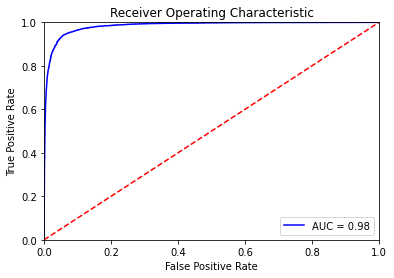

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_probs[:,1].numpy())
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()